# First, we need to figure out the right parameter settings 

In [2]:
import gzip

with gzip.open('../split_gen_ihart_chip/merge_w2w3w4w5w6w1_trial1_recode_remove_fams_vcf.vcf.gz', 'rt') as f:
    # skip header
    line = next(f)
    while line.startswith('#'):
        line = next(f)
    
    # count sites
    num_sites = len([x for x in f])
print(num_sites)

547643


In [3]:
print(35/num_sites) # so we set deletion_cost to 5 and recombination_cost to 3

6.391024809958312e-05


# Compare sibpair similarity in iHART WGS vs chip

In [4]:
from collections import defaultdict, Counter
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib

In [5]:
# need affected/unaffected information
# these files can be found on sherlock
# '../data/v34.vcf.ped' = /scratch/PI/dpwall/DATA/iHART/vcf/v3.4/v34.vcf.ped
# '../data/ssc.ped' = /scratch/PI/dpwall/DATA/iHART/vcf/SSC/ssc.ped

ped_files = ['../data/v34.vcf.ped']
# Affection (0=unknown; 1=unaffected; 2=affected)
child_id_to_affected = dict()
child_id_to_sex = dict()

for ped_file in ped_files:
    with open(ped_file, 'r') as f:
        for line in f:
            pieces = line.strip().split('\t')
            if len(pieces) >= 6:
                fam_id, child_id, f_id, m_id, sex, disease_status = pieces[0:6]
                child_id_to_affected[child_id] = disease_status
                child_id_to_sex[child_id] = sex

In [6]:
# for this analysis, we remove families with monozygotic multiples

monozygotic_multiple_families = set()
with open('../data/160826.iHART.db.query.csv', 'r') as f:
    next(f)
    for line in f:
        pieces = line.split(',')
        if 'MZ' in pieces[11]:
            monozygotic_multiple_families.add(pieces[3])
print('Mono multiples', len(monozygotic_multiple_families))

Mono multiples 96


In [7]:
chroms = [str(x) for x in range(1, 23)] #+ ['X']

family_sizes = [4]
ihart_wgs_phase_dir = '../phased_ihart_quad'
ihart_chip_phase_dir = '../phased_ihart_chip_quad'


In [8]:
# filter families by various criteria

def pull_ok_families(phase_dir, family_sizes):

    # make sure we have data from every chromosome for each family
    family_to_chroms = defaultdict(set)
    family_to_individuals = dict()
    for chrom in chroms:
        print(chrom, end=' ')

        for j in family_sizes:
            try:
                with open('%s/chr.%s.familysize.%d.families.txt' % (phase_dir, chrom, j), 'r') as f:
                    next(f) # skip header
                    for line in f:
                        pieces = line.strip().split('\t')
                        family_key = pieces[0]
                        family_to_chroms[family_key].add(chrom)
                        family_to_individuals[family_key] = pieces[1:(1+j)]
            except FileNotFoundError:
                print('File not found', 'chrom', chrom, 'family size', j)
            except StopIteration:
                print('File empty', 'chrom', chrom, 'family size', j)

    families_with_all_chroms = set([k for k, v in family_to_chroms.items() if len(v)==len(chroms)])
    print('Families with all chroms', len(families_with_all_chroms))
    print(Counter([len(v) for v in family_to_chroms.values()]))
    
    # some individuals in iHART have data on WB and LCL, we these families as well, since the phasing algorithm 
    # naively treated these samples as coming from different people - I need to go back and fix this
    families_with_lcl = set([x for x, inds in family_to_individuals.items() if len([y for y in inds if 'LCL' in y]) > 0])
    print('Families with LCL', len(families_with_lcl))
    
    families_to_include = dict([(x, family_to_individuals[x]) for x in families_with_all_chroms if x not in families_with_lcl and x.split('.')[0]  not in monozygotic_multiple_families])
    print('Final families', len(families_to_include))
    
    return families_to_include

ok_ihart_wgs_families = pull_ok_families(ihart_wgs_phase_dir, family_sizes)
ok_ihart_chip_families = pull_ok_families(ihart_chip_phase_dir, family_sizes)

overlap_families = dict([(k, ok_ihart_wgs_families[k]) for k in set(ok_ihart_wgs_families.keys()) & set(ok_ihart_chip_families.keys())])
print('Overlap', len(overlap_families))



1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 Families with all chroms 1976
Counter({22: 1976, 21: 73})
Families with LCL 0
Final families 1757
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 Families with all chroms 700
Counter({22: 700})
Families with LCL 0
Final families 697
Overlap 636


In [9]:
from collections import defaultdict, namedtuple
from uuid import uuid4

# read in phase information
Interval = namedtuple('Interval', ['id', 'chrom', 'start_pos', 'end_pos', 'length', 'has_m1', 'has_m2', 'has_p1', 'has_p2', 'm_unknown', 'p_unknown'])

def load_intervals(phase_dir, family_sizes, families_to_include):
    family_to_intervals = defaultdict(list)
    for chrom in chroms:
        print(chrom, end=' ')

        for j in family_sizes:
            try:
                with open('%s/chr.%s.familysize.%d.families.txt' % (phase_dir, chrom, j), 'r')  as f:
                    family_to_individuals = dict()
                    next(f) # skip header
                    num_fams_of_size = 0
                    for line in f:
                        pieces = line.strip().split('\t')
                        family_key = pieces[0]
                        if family_key in families_to_include.keys():
                            family_to_individuals[family_key] = pieces[1:(1+j)]
                            num_fams_of_size += 1

                # load deletions
                with open('%s/chr.%s.familysize.%d.phased.txt' % (phase_dir, chrom, j), 'r')  as f:
                    next(f) # skip header

                    for line in f:
                        pieces = line.strip().split('\t')
                        family_key = pieces[0]
                        if family_key in families_to_include.keys():
                            inheritance_state = [int(x) for x in pieces[1:(2+(j*2))]]
                            start_pos, end_pos = [int(x) for x in pieces[(2+(j*2)):(4+(j*2))]]
                            length = end_pos - start_pos + 1
                            if length < 0:
                                print(line)

                            has_m1, has_m2, has_p1, has_p2 = [], [], [], []
                            children = family_to_individuals[family_key][2:]
                            if inheritance_state[-1] != 1:
                                for i, child in enumerate(children):
                                    if inheritance_state[4+2*i] == 0:
                                        has_m1.append(child)
                                    elif inheritance_state[4+2*i] == 1:
                                        has_m2.append(child)
                                    if inheritance_state[5+2*i] == 0:
                                        has_p1.append(child)
                                    elif inheritance_state[5+2*i] == 1:
                                        has_p2.append(child)

                            m_unknown = list(set(children) - set(has_m1 + has_m2))
                            p_unknown = list(set(children) - set(has_p1 + has_p2))

                            family_to_intervals[family_key].append(Interval(uuid4(), chrom, start_pos, end_pos, length,
                                                                             has_m1, has_m2, has_p1, has_p2,
                                                                             m_unknown, p_unknown))



            except FileNotFoundError:
                print('File not found', 'chrom', chrom, 'fammily size', j)
            except StopIteration:
                print('File empty', 'chrom', chrom, 'family size', j)
                
    return family_to_intervals

def load_intervals_new(phase_dir, family_sizes, families_to_include):
    family_to_intervals = defaultdict(list)
    for chrom in chroms:
        print(chrom, end=' ')

        for j in family_sizes:
            try:
                with open('%s/chr.%s.familysize.%d.families.txt' % (phase_dir, chrom, j), 'r')  as f:
                    family_to_individuals = dict()
                    next(f) # skip header
                    num_fams_of_size = 0
                    for line in f:
                        pieces = line.strip().split('\t')
                        family_key = pieces[0]
                        if family_key in families_to_include.keys():
                            family_to_individuals[family_key] = pieces[1:(1+j)]
                            num_fams_of_size += 1

                # load deletions
                with open('%s/chr.%s.familysize.%d.phased.txt' % (phase_dir, chrom, j), 'r')  as f:
                    next(f) # skip header

                    for line in f:
                        pieces = line.strip().split('\t')
                        family_key = pieces[0]
                        if family_key in families_to_include.keys():
                            inheritance_state = [int(x) for x in pieces[1:(1+(j*2))]]
                            start_pos, end_pos = [int(x) for x in pieces[(1+(j*2)):(3+(j*2))]]
                            length = end_pos - start_pos + 1
                            if length < 0:
                                print(line)

                            has_m1, has_m2, has_p1, has_p2 = [], [], [], []
                            children = family_to_individuals[family_key][2:]
                            for i, child in enumerate(children):
                                if inheritance_state[4+2*i] == 0:
                                    has_m1.append(child)
                                elif inheritance_state[4+2*i] == 1:
                                    has_m2.append(child)
                                if inheritance_state[5+2*i] == 0:
                                    has_p1.append(child)
                                elif inheritance_state[5+2*i] == 1:
                                    has_p2.append(child)

                            m_unknown = list(set(children) - set(has_m1 + has_m2))
                            p_unknown = list(set(children) - set(has_p1 + has_p2))

                            family_to_intervals[family_key].append(Interval(uuid4(), chrom, start_pos, end_pos, length,
                                                                             has_m1, has_m2, has_p1, has_p2,
                                                                             m_unknown, p_unknown))



            except FileNotFoundError:
                print('File not found', 'chrom', chrom, 'fammily size', j)
            except StopIteration:
                print('File empty', 'chrom', chrom, 'family size', j)
                
    return family_to_intervals

ihart_wgs_intervals = load_intervals(ihart_wgs_phase_dir, family_sizes, overlap_families)
ihart_chip_intervals = load_intervals(ihart_chip_phase_dir, family_sizes, overlap_families)



1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 1 2 3 4 5 6 7 8 9 10 11 12 13 AU1166.AU1166301.AU1166302.AU1166202.AU1166201	1	-1	1	-1	0	0	-1	0	0	108799307	108799305	13602	13602	-1	1

14 15 16 17 18 19 20 21 22 

In [10]:
from itertools import product, chain

# calculate maternal and paternal similarity between sibpairs

SibPair = namedtuple('SibPair', ['child1', 'child2', 'shared'])

def calculate_sibpair_similarity(family_to_intervals, family_to_individuals, weights=None):
    sibpairs = dict()

    for family_key, intervals in family_to_intervals.items():
        children = family_to_individuals[family_key][2:]
        for child1 in children:
            for child2 in children:
                if child1 < child2:
                    sibpairs[(child1, child2)] = SibPair(child1, child2, {'mat_same': 0, 'mat_diff': 0, 
                                                                          'pat_same': 0, 'pat_diff': 0,
                                                                         'both_same': 0, 'both_diff': 0})

        for i in intervals:
            if weights is None:
                bp = i.length
            else:
                bp = weights[i.id]
            
            mat_shared = list(chain(product(i.has_m1, repeat=2), product(i.has_m2, repeat=2)))
            for child1, child2 in mat_shared:
                if child1 < child2:
                    sibpairs[(child1, child2)].shared['mat_same'] += bp

            mat_different = list(chain(product(i.has_m1, i.has_m2), product(i.has_m2, i.has_m1)))
            for child1, child2 in mat_different:
                if child1 < child2:
                    sibpairs[(child1, child2)].shared['mat_diff'] += bp

            pat_shared = list(chain(product(i.has_p1, repeat=2), product(i.has_p2, repeat=2)))
            for child1, child2 in pat_shared:
                if child1 < child2:
                    sibpairs[(child1, child2)].shared['pat_same'] += bp

            pat_different = list(chain(product(i.has_p1, i.has_p2), product(i.has_p2, i.has_p1)))
            for child1, child2 in pat_different:
                if child1 < child2:
                    sibpairs[(child1, child2)].shared['pat_diff'] += bp

            for child1, child2 in set(mat_shared) & set(pat_shared):
                if child1 < child2:
                    sibpairs[(child1, child2)].shared['both_same'] += bp

            for child1, child2 in set(mat_different) | set(pat_different):
                if child1 < child2:
                    sibpairs[(child1, child2)].shared['both_diff'] += bp
    return sibpairs

ihart_wgs_sps = calculate_sibpair_similarity(ihart_wgs_intervals, overlap_families)
ihart_chip_sps = calculate_sibpair_similarity(ihart_chip_intervals, overlap_families)


In [11]:
sps_keys = sorted(ihart_wgs_sps.keys()) # same for both

ihart_wgs_mat = np.asarray([x.shared['mat_same']/(x.shared['mat_same']+x.shared['mat_diff']) for x in [ihart_wgs_sps[y] for y in sps_keys]])
ihart_wgs_pat = np.asarray([x.shared['pat_same']/(x.shared['pat_same']+x.shared['pat_diff']) for x in [ihart_wgs_sps[y] for y in sps_keys]])
ihart_wgs_both = np.asarray([x.shared['both_same']/(x.shared['both_same']+x.shared['both_diff']) for x in [ihart_wgs_sps[y] for y in sps_keys]])

ihart_chip_mat = np.asarray([0 if (x.shared['mat_same']+x.shared['mat_diff']) == 0 else x.shared['mat_same']/(x.shared['mat_same']+x.shared['mat_diff']) for x in [ihart_chip_sps[y] for y in sps_keys]])
ihart_chip_pat = np.asarray([0 if (x.shared['pat_same']+x.shared['pat_diff']) == 0 else x.shared['pat_same']/(x.shared['pat_same']+x.shared['pat_diff']) for x in [ihart_chip_sps[y] for y in sps_keys]])
ihart_chip_both = np.asarray([0 if (x.shared['both_same']+x.shared['both_diff']) == 0 else x.shared['both_same']/(x.shared['both_same']+x.shared['both_diff']) for x in [ihart_chip_sps[y] for y in sps_keys]])


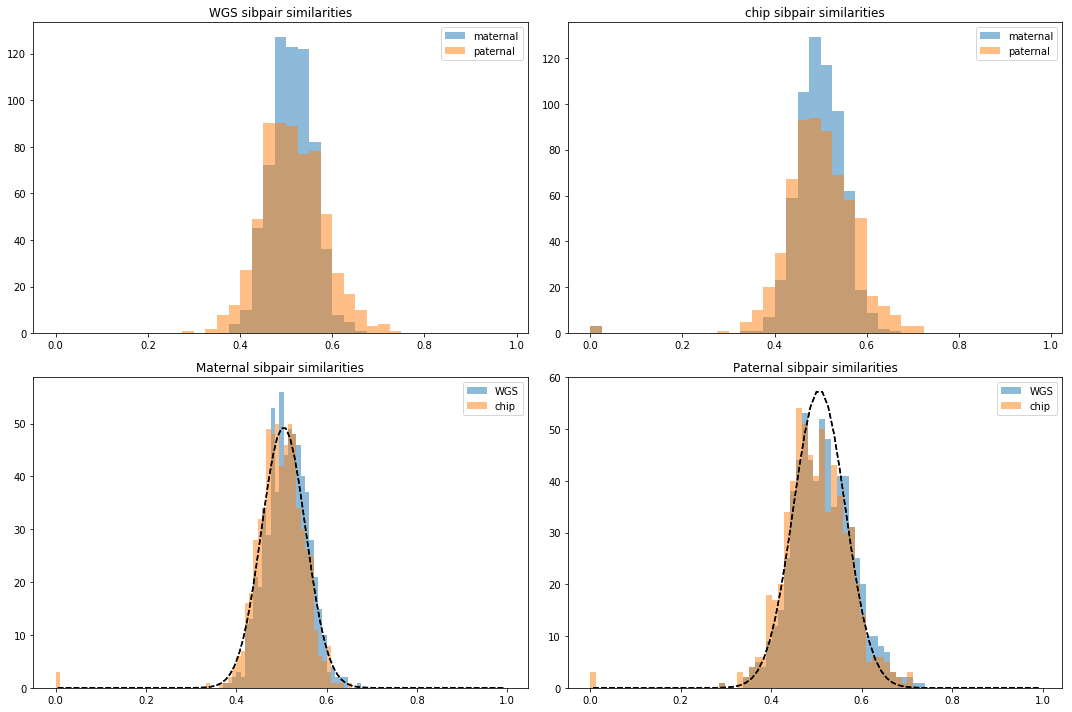

In [12]:
import scipy.stats as stats

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.hist(ihart_wgs_mat, bins=np.arange(0, 1, .025), alpha=0.5, label='maternal')
plt.hist(ihart_wgs_pat, bins=np.arange(0, 1, .025), alpha=0.5, label='paternal')
plt.title('WGS sibpair similarities')
plt.legend()

plt.subplot(2, 2, 2)
plt.hist(ihart_chip_mat, bins=np.arange(0, 1, .025), alpha=0.5, label='maternal')
plt.hist(ihart_chip_pat, bins=np.arange(0, 1, .025), alpha=0.5, label='paternal')
plt.title('chip sibpair similarities')
plt.legend()

plt.subplot(2, 2, 3)
p = 0.5
n = (21+(2*42))
x_axis = np.arange(0, n)
plt.plot((x_axis+0.5)/n, len(ihart_wgs_mat)*stats.binom.pmf(x_axis, n, p), color='black', linestyle='--')
plt.plot((x_axis+0.5)/n, len(ihart_chip_mat)*stats.binom.pmf(x_axis, n, p), color='black', linestyle='--')
plt.hist(ihart_wgs_mat, bins=x_axis/n, alpha=0.5, label='WGS')
plt.hist(ihart_chip_mat, bins=x_axis/n, alpha=0.5, label='chip')
plt.legend()
plt.title('Maternal sibpair similarities')

plt.subplot(2, 2, 4)
n = (21+(2*28))
x_axis = np.arange(0, n)
plt.plot((x_axis+0.5)/n, len(ihart_wgs_pat)*stats.binom.pmf(x_axis, n, p), color='black', linestyle='--')
plt.plot((x_axis+0.5)/n, len(ihart_chip_pat)*stats.binom.pmf(x_axis, n, p), color='black', linestyle='--')
plt.hist(ihart_wgs_pat, bins=x_axis/n, alpha=0.5, label='WGS')
plt.hist(ihart_chip_pat, bins=x_axis/n, alpha=0.5, label='chip')
plt.legend()
plt.title('Paternal sibpair similarities')

plt.tight_layout()
plt.show()

In [13]:
is_ok = [a != 0 and b != 0 and c != 0 and d != 0 for a, b, c, d in zip(ihart_wgs_mat, ihart_wgs_pat, ihart_chip_mat, ihart_chip_pat)]
print('WGS Maternal', np.median(ihart_wgs_mat[is_ok]))
print('WGS Paternal', np.median(ihart_wgs_pat[is_ok]))
print('Chip Maternal', np.median(ihart_chip_mat[is_ok]))
print('Chip Paternal', np.median(ihart_chip_pat[is_ok]))



WGS Maternal 0.513050267171
WGS Paternal 0.510939229879
Chip Maternal 0.498678039558
Chip Paternal 0.498146743857


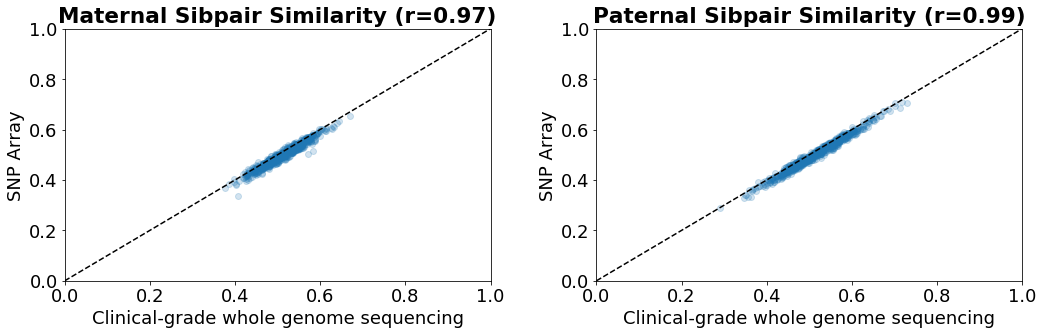

In [19]:
from scipy.stats.stats import pearsonr

matplotlib.rcParams.update({'font.size': 18})

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.scatter(ihart_wgs_mat[is_ok], ihart_chip_mat[is_ok], alpha=0.2)
plt.xlabel('Clinical-grade whole genome sequencing')
plt.ylabel('SNP Array')
plt.title('Maternal Sibpair Similarity (r=%0.2f)' % pearsonr(ihart_wgs_mat[is_ok], ihart_chip_mat[is_ok])[0],fontweight="bold")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.plot([0, 1], [0, 1], linestyle='--', color='black')

plt.subplot(1, 2, 2)
plt.scatter(ihart_wgs_pat[is_ok], ihart_chip_pat[is_ok], alpha=0.2)
plt.xlabel('Clinical-grade whole genome sequencing')
plt.ylabel('SNP Array')
plt.title('Paternal Sibpair Similarity (r=%0.2f)' % pearsonr(ihart_wgs_pat[is_ok], ihart_chip_pat[is_ok])[0],fontweight="bold")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.plot([0, 1], [0, 1], linestyle='--', color='black')

plt.tight_layout()
plt.show()

# Now look at recombinations

In [15]:
def calculate_recombs(all_intervals):
    sibpair_to_mat_recombs = defaultdict(int)
    sibpair_to_pat_recombs = defaultdict(int)

    for famkey, intervals in all_intervals.items():
        child1, child2 = famkey.split('.')[1:3]

        old_chrom = None
        child1_was_in_m1, child1_was_in_p1, child2_was_in_m1, child2_was_in_p1 = None, None, None, None
        for interval in intervals:
            child1_is_in_m1 = True if child1 in interval.has_m1 else False if child1 in interval.has_m2 else None
            child1_is_in_p1 = True if child1 in interval.has_p1 else False if child1 in interval.has_p2 else None
            child2_is_in_m1 = True if child2 in interval.has_m1 else False if child2 in interval.has_m2 else None
            child2_is_in_p1 = True if child2 in interval.has_p1 else False if child2 in interval.has_p2 else None

            if old_chrom == interval.chrom:
                if child1_was_in_m1 is not None and child1_is_in_m1 is not None and child1_was_in_m1 != child1_is_in_m1:
                    sibpair_to_mat_recombs[(child1, child2)] += 1
                if child1_was_in_p1 is not None and child1_is_in_p1 is not None and child1_was_in_p1 != child1_is_in_p1:
                    sibpair_to_pat_recombs[(child1, child2)] += 1
                if child2_was_in_m1 is not None and child2_is_in_m1 is not None and child2_was_in_m1 != child2_is_in_m1:
                    sibpair_to_mat_recombs[(child1, child2)] += 1
                if child2_was_in_p1 is not None and child2_is_in_p1 is not None and child2_was_in_p1 != child2_is_in_p1:
                    sibpair_to_pat_recombs[(child1, child2)] += 1

            if child1_is_in_m1 is not None:
                child1_was_in_m1 = child1_is_in_m1
            if child1_is_in_p1 is not None:
                child1_was_in_p1 = child1_is_in_p1
            if child2_is_in_m1 is not None:
                child2_was_in_m1 = child2_is_in_m1
            if child2_is_in_p1 is not None:
                child2_was_in_p1 = child2_is_in_p1

            old_chrom = interval.chrom
    return sibpair_to_mat_recombs, sibpair_to_pat_recombs
        
ihart_wgs_mat_recombs, ihart_wgs_pat_recombs = calculate_recombs(ihart_wgs_intervals)
ihart_chip_mat_recombs, ihart_chip_pat_recombs = calculate_recombs(ihart_chip_intervals)

ihart_wgs_mat_recombs = np.asarray([ihart_wgs_mat_recombs[x] for x in sps_keys])
ihart_wgs_pat_recombs = np.asarray([ihart_wgs_pat_recombs[x] for x in sps_keys])
ihart_chip_mat_recombs = np.asarray([ihart_chip_mat_recombs[x] for x in sps_keys])
ihart_chip_pat_recombs = np.asarray([ihart_chip_pat_recombs[x] for x in sps_keys])

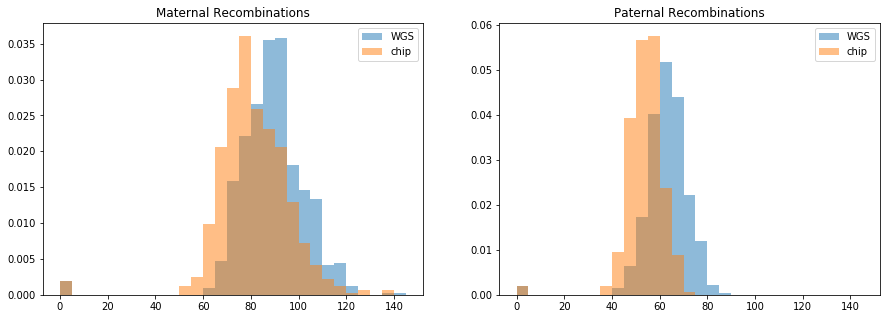

In [16]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.hist(ihart_wgs_mat_recombs[is_ok], alpha=0.5, label='WGS', density=True, bins=range(0, 150, 5))
plt.hist(ihart_chip_mat_recombs[is_ok], alpha=0.5, label='chip', density=True, bins=range(0, 150, 5))
plt.title('Maternal Recombinations')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(ihart_wgs_pat_recombs[is_ok], alpha=0.5, label='WGS', density=True, bins=range(0, 150, 5))
plt.hist(ihart_chip_pat_recombs[is_ok], alpha=0.5, label='chip', density=True, bins=range(0, 150, 5))
plt.title('Paternal Recombinations')
plt.legend()

plt.show()

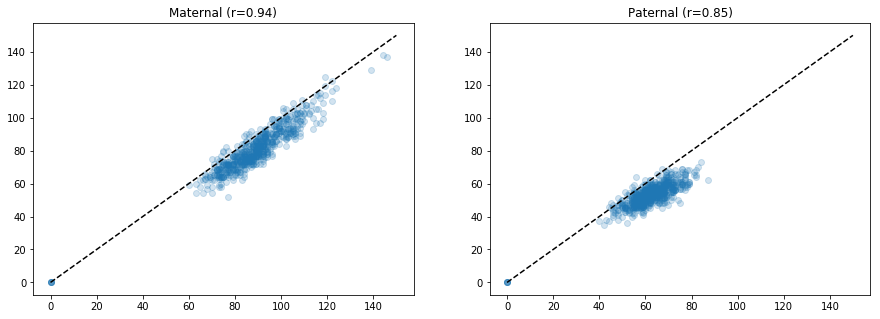

In [17]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.scatter(ihart_wgs_mat_recombs[is_ok], ihart_chip_mat_recombs[is_ok], alpha=0.2)
plt.plot([0, 150], [0, 150], color='black', linestyle='--')
plt.title('Maternal (r=%0.2f)' % pearsonr(ihart_wgs_mat_recombs[is_ok], ihart_chip_mat_recombs[is_ok])[0])

plt.subplot(1, 2, 2)
plt.scatter(ihart_wgs_pat_recombs[is_ok], ihart_chip_pat_recombs[is_ok], alpha=0.2)
plt.plot([0, 150], [0, 150], color='black', linestyle='--')
plt.title('Paternal (r=%0.2f)' % pearsonr(ihart_wgs_pat_recombs[is_ok], ihart_chip_pat_recombs[is_ok])[0])

plt.show()

In [20]:
import random

famkey = random.choice(list(ihart_wgs_intervals.keys()))
wgs_intervals = ihart_wgs_intervals[famkey]
chip_intervals = ihart_chip_intervals[famkey]

In [21]:
positions = sorted(set([(i.chrom, i.start_pos) for i in wgs_intervals] \
                       + [(i.chrom, i.end_pos) for i in wgs_intervals] \
                       + [(i.chrom, i.start_pos) for i in chip_intervals] \
                       + [(i.chrom, i.end_pos) for i in chip_intervals]), key=lambda x: (int(x[0]), x[1]))
pos_to_index = dict([(x, i) for i, x in enumerate(positions)])
n = len(positions)
print('positions', n)

positions 2207


In [22]:
child1, child2 = famkey.split('.')[1:3]

def generate_inheritance_pattern(intervals):
    mat_trans_pattern = -np.ones((n+1,), dtype=int)
    pat_trans_pattern = -np.ones((n+1,), dtype=int)
    for i in intervals:
        start_index, end_index = pos_to_index[(i.chrom, i.start_pos)], pos_to_index[(i.chrom, i.end_pos)]+1
        if (child1 in i.has_m1 and child2 in i.has_m1) or (child1 in i.has_m2 and child2 in i.has_m2):
            mat_trans_pattern[start_index:end_index] = 0
        elif (child1 in i.has_m1 and child2 in i.has_m2) or (child1 in i.has_m2 and child2 in i.has_m1):
            mat_trans_pattern[start_index:end_index] = 1
        
        if (child1 in i.has_p1 and child2 in i.has_p1) or (child1 in i.has_p2 and child2 in i.has_p2):
            pat_trans_pattern[start_index:end_index] = 0
        elif (child1 in i.has_p1 and child2 in i.has_p2) or (child1 in i.has_p2 and child2 in i.has_p1):
            pat_trans_pattern[start_index:end_index] = 1
    return mat_trans_pattern, pat_trans_pattern

wgs_mat_trans_pattern, wgs_pat_trans_pattern = generate_inheritance_pattern(wgs_intervals)
chip_mat_trans_pattern, chip_pat_trans_pattern = generate_inheritance_pattern(chip_intervals)



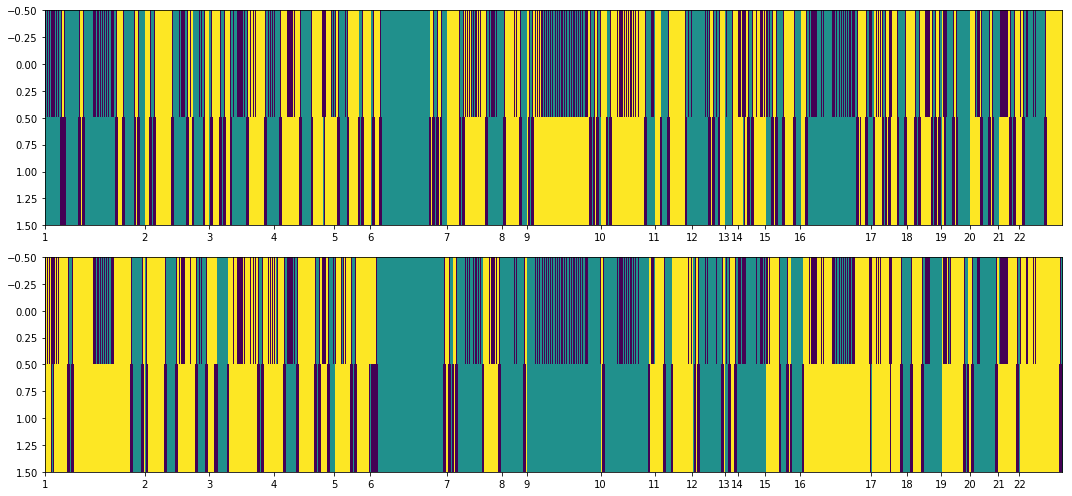

In [23]:
ticks = [min([i for i, (c, p) in enumerate(positions) if c==chrom]) for chrom in chroms]

plt.figure(figsize=(15, 7))

plt.subplot(2, 1, 1)
plt.imshow(np.vstack((wgs_mat_trans_pattern, chip_mat_trans_pattern)), aspect='auto', vmin=-1, vmax=1)
plt.xticks(ticks, chroms)

plt.subplot(2, 1, 2)
plt.imshow(np.vstack((wgs_pat_trans_pattern, chip_pat_trans_pattern)), aspect='auto', vmin=-1, vmax=1)
plt.xticks(ticks, chroms)

plt.tight_layout()
plt.show()

In [24]:
chrom_lengths = {
	'1': 249250621,
	'2': 243199373,
	'3': 198022430,
	'4': 191154276,
	'5': 180915260,
	'6': 171115067,
	'7': 159138663,
	'8': 146364022,
	'9': 141213431,
	'10': 135534747,
	'11': 135006516,
	'12': 133851895,
	'13': 115169878,
	'14': 107349540,
	'15': 102531392,
	'16': 90354753,
	'17': 81195210,
	'18': 78077248,
	'19': 59128983,
	'20': 63025520,
	'21': 48129895,
	'22': 51304566,
	'X': 155270560,
	'Y': 59373566
}
chrom_starts = dict([(chroms[i], sum([chrom_lengths[c] for c in chroms[:i]])) for i in range(len(chroms))])

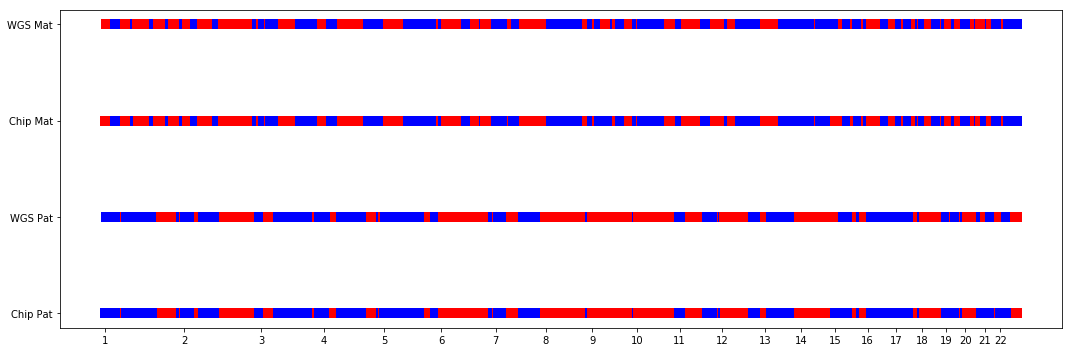

In [25]:
final_pos = [chrom_starts[c]+p for c, p in positions]

plt.figure(figsize=(15, 5))

def plot_on_line(trans_pattern, y):
    for i, (prev_p, prev_tp) in enumerate(zip(final_pos[:-1], trans_pattern[:-2])):
        p, tp = final_pos[i+1], trans_pattern[i+1]
        if prev_tp == tp:
            if tp == 0:
                plt.plot([prev_p, p], [y, y], color='red', linewidth=10)
            elif tp == 1:
                plt.plot([prev_p, p], [y, y], color='blue', linewidth=10)

plot_on_line(wgs_mat_trans_pattern, 4)
plot_on_line(chip_mat_trans_pattern, 3)
plot_on_line(wgs_pat_trans_pattern, 2)
plot_on_line(chip_pat_trans_pattern, 1)

plt.xticks([chrom_starts[c] for c in chroms], chroms)
plt.yticks([1, 2, 3, 4], ['Chip Pat', 'WGS Pat', 'Chip Mat', 'WGS Mat'])
plt.tight_layout()
plt.show()